### Problem Statement

The BBC points out that global meat consumption has [increased rapidly over the last 50 years](https://www.bbc.com/news/health-47057341). The article states that the richer the country, the greater the meat consumption. If we were to identify trends and patterns in meat consumption that are associated with changes in GDP in [GDP data collected from The World Bank](https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.PCAP.CD&country=), then we can provide evidence to the idea that GDP growth does indeed influcence meat consumption. [Meat production has a large environmental impact](https://www.greenpeace.org.uk/news/why-meat-is-bad-for-the-environment/), which includes deforestation to build industrial meat farms, billions of tons of carbon dioxide being released into the atmosphere, feed sourcing, and manure processing, to name a few. Therefore, countries that consume the most amount of meat should do their part to reduce the environmental impact of meat consumption.

### Additional Data Links

- [Meat consumption data from OECD](https://data.oecd.org/agroutput/meat-consumption.htm)

### Import Libraries

In [1]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy import sort
from final_project import plotting

- Get 5 richest countries and 5 poorest countries from OECD data and plot the meat consumption for these countries on either 5 separate graphs or one large graph. Use this as the ranking for the richest and poorest countries.

### Import Data

The yearly GDP data was collected from Wikipedia and consists of estimates from the UN. It has already ben adjusted by a per capita basis. Note that we could use `pd.read_html` to automatically import the data from Wikipedia and then use indexing to select which tables we would want, which in our case are the tables that give us the UN estimates. 

However, from personal experience, `pd.read_html` takes about a minute to import the data. I felt that this was a bit of a long wait, so I collected the data from the tables after using `pd.read_html` once, and then saved the data to a `.csv`. Then I uploaded the data into the forked repository for this class. So now I can quickly import the `.csv` file into this notebook. 

Depending on the data, this might not be the best option. For example, for data that is updated frequently, importing a static data file might not be the best option. However, for our project, this data has not been updated since 2015, and even if it was updated, it would probably only be done on a once-a-year basis since this is YEARLY GDP by capita data. Therefore, for all intents and purposes, importing the data from a static `.csv` file seems like a good option for this project.

In [2]:
# OECD Meat Consumption Data
meat_consumption_df = pd.read_csv(
    filepath_or_buffer="https://raw.githubusercontent.com/peterphung2043/CUNY_DATA_608/master/Final%20Project/data/world_meat_consumption.csv"
)

# GDP Per Capita Data collected from The World Bank
gdp_per_cap_df = pd.read_csv(
    filepath_or_buffer="/home/peter/MSDS CUNY SPS/DATA 608/CUNY_DATA_608/Final Project/data/gdp_data.csv",
    nrows = 266,
    na_values=".."
).drop(columns = ['Series Name', 'Series Code'])

The `gdp_per_cap_df` dataframe came with several columns that we do not need which we've parsed out in the code chunk above:

- `Series Name`: Only has one unique value (GDP per capita (current US$))
- `Series Code`: Only has one unique value (NY.GDP.PCAP.CD)

# Data Pre-Processing

### Display Imported Dataframes

We display the two dataframes as shown below.

In [3]:
display(meat_consumption_df.head())
display(gdp_per_cap_df.head())

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN
3,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1993,26.370,NaN
4,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1994,25.662,NaN


,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],1967 [YR1967],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Afghanistan,AFG,62.369375,62.443703,60.950364,82.021738,85.511073,105.243196,143.103233,167.165675,...,663.141053,651.987862,628.146804,592.476537,520.252064,530.149831,502.056771,500.522664,516.866552,368.754614
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4247.630047,4413.062005,4578.633208,3952.802538,4124.055390,4531.019374,5287.663694,5396.215864,5332.160475,6492.872012
2,Algeria,DZA,239.031069,209.915477,169.925637,225.821562,238.875870,253.307007,241.000619,261.364116,...,5610.730894,5519.777576,5516.230604,4197.421361,3967.199451,4134.936720,4171.795011,4022.150184,3337.252512,3690.627878
3,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11920.061090,12038.871592,12313.997357,13101.541816,13300.824611,12372.884783,13195.935900,13672.576657,15501.526337,15743.310758
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44904.580043,44750.435680,45682.246231,38885.376014,39932.164487,40632.484393,42903.443579,41327.502031,37207.493861,42137.327271


Notice how each of the years in the `gdp_per_cap_df` dataframe are represented by `XXXX [YRXXXX]` where `XXXX` represents the year of the observations. Let's rename all of these and then use the `melt` function in `pandas` to nicely merge the `meat_consumption_df` dataframe with the `gdp_per_cap_df` dataframe.

In [4]:
gdp_per_cap_df = gdp_per_cap_df.rename(columns = (lambda x: x[:4] if x not in ['Country Code', 'Country Name'] else x)).melt(id_vars=['Country Code', 'Country Name']).rename(columns = {'variable': 'Year', 'value': 'GDP Per Capita'}).astype({'Year': "int64"})

Note that `Value` in the `meat_consumption_df` dataframe represents either:
- The amount of kilograms of meat consumed (see the `MEASURE` variable in the same dataframe)
- The amount of meat consumed in thousands of tonnes (not shown in the output above, but is represented as `THND_TONNE` in the `MEASURE` variable)

The `SUBJECT` variable in the `meat_consumption_df` dataframe represents the meat type that is consumed. The different meat types are:
- `BEEF`
- `PIG`
- `POULTRY`
- `SHEEP`

### Merging Meat Consumption with GDP Per Capita Data

Notice that the `meat_consumption_df` each row of `LOCATION` contains a 3 letter abbreviation of the country that the observation is representing. The `Country Code` column in the `gdp_per_cap_df` also contains a 3 letter abbreviation of the country. We can merge the two dataframes together based on these columns.

In [5]:
meat_and_gdp_df = pd.merge(meat_consumption_df, gdp_per_cap_df, left_on=['LOCATION', 'TIME'], right_on=['Country Code', 'Year']).query('MEASURE == \'KG_CAP\' & Value != 0').drop(columns=['TIME', 'Country Code', 'INDICATOR', 'FREQUENCY', 'Flag Codes', 'LOCATION', 'MEASURE']).rename(columns = {'Country Name': 'Country'})
meat_and_gdp_df.head()

,SUBJECT,Value,Country,Year,GDP Per Capita
2,POULTRY,22.051,Australia,1990,18249.709485
3,SHEEP,19.013,Australia,1990,18249.709485
8,BEEF,27.942,Australia,1991,18860.581591
9,PIG,14.521,Australia,1991,18860.581591
10,POULTRY,22.350,Australia,1991,18860.581591


Some of the columns are not needed from the meat consumption dataset. These include:
- `INDICATOR`: Let's the user know which agricultural sector the observation represents, since OECD provides more agricultural data. Since the imported data is all meat consumption however, this column is useless.
- `FREQUENCY`: Represents the time frequency of the observation. Since all of the data was collected at an annual frequency, there is only one value that this column can take, which also makes this column useless.
- `Flag Code`: All `NaN`s.

The amount of meat consumed can be represented in two ways based on the `MEASURE` variable:

- `KG_CAP`: The amount of kilograms of meat eaten per capita
- `THND_TONNE`: Annual consumption in thousands of tonnes

Both of these represent the same information (amount of meat consumed) but in different units of measurement. So for this project, only the meat consumed in `KG_CAP` is considered. Therefore, we can get rid of the `MEASURE` variable, since all of the values in `VALUE` represent just the `KG_CAP`.

Note that the `meat_and_gdp_df` dataframe does not contain 2 `LOCATION`s that were in the original `meat_consumption_df`. These 2 `LOCATIONS` are: 

- `OECD`: [An intergovernmental organisation with 38 member countries](https://en.wikipedia.org/wiki/OECD)
- `BRICS`: An acronym for 5 leading economies: Brazil, Russia, India, China, and South Africa

Note also that there were some observations in the dataset where `Value = 0`, basically indicating that for that particular year, there is no meat consumption data for that country. This interferes greatly with the correlations that are calculated later in the notebook. The observations where `Value = 0` were omitted to mitigate this.

Ultimately, we are trying to see if there is a correlation between GDP Per Capita and Meat Consumption Per Capita. What I propose is that we plot:

- `GDP Per Capita` on the left y-axis
- `Value` on the right y-axis
- `Year` on the x-axis

We can also display the correlation between the `GDP Per Capita` and the `Value` for each `SUBJECT`

### Dash App

Running the code chunk below will activate the Dash app. See the `Final Project/final_project/src/app.py` file for more details.

In [6]:
!python final_project/src/app.py

Dash is running on http://127.0.0.1:8000/

 * Serving Flask app 'app'
 * Debug mode: on
^C


### Figures for Analytics

The figure below is a compilation of the time series and correlation figures for the top 5 highest and lowest GDP per capita countries. The countries in the top are the top 5 highest and the countries on the bottom are the top 5 lowest.

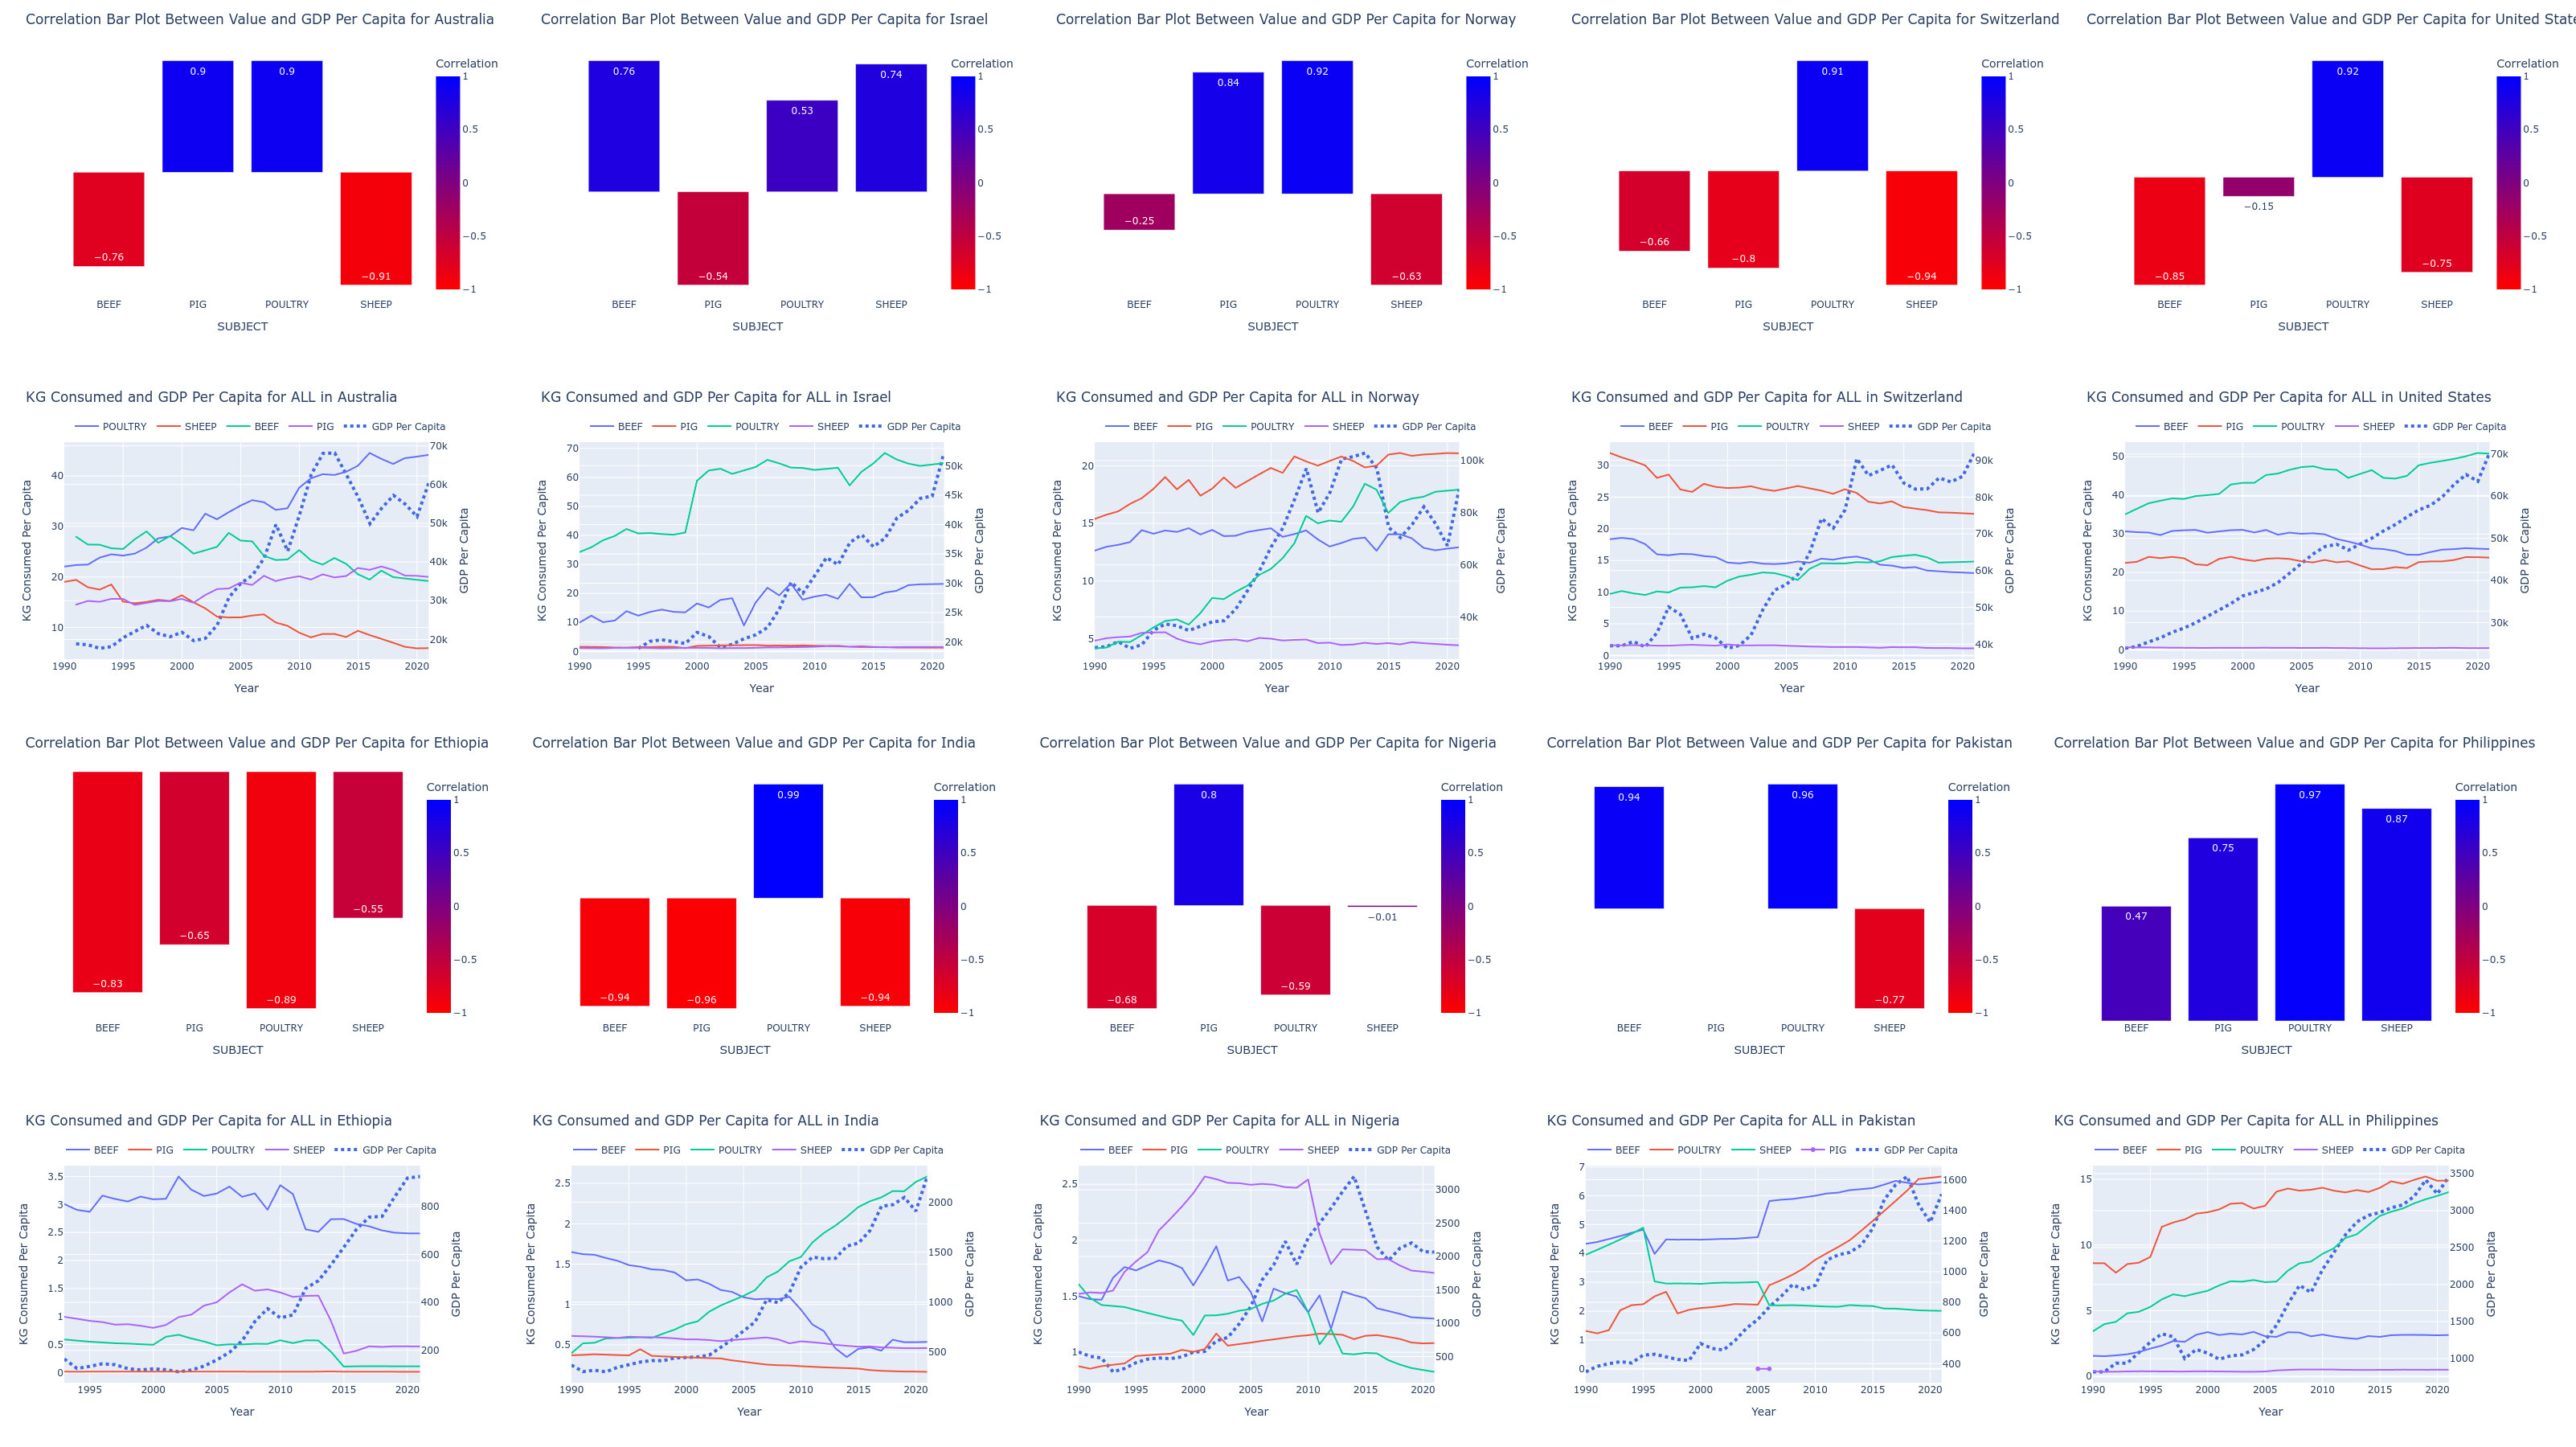

In [20]:
%matplotlib inline
from IPython.display import Image
Image('https://raw.githubusercontent.com/peterphung2043/CUNY_DATA_608/master/Final%20Project/images/BigBoy.jpg')

### Countries with the highest GDP Per Capita

In the plot above, notice how for all 5 countries with the highest GDP per capitas, `Poultry` consumption per capita and GDP per capita have a really strong correlation. 4 out of the 5 countries have negative correlation betwen `Beef` consumption and GDP per capita. Some countries have a really strong positive correlation between `Pig` consumption per capita and GDP per capita (Australia, Norway), while others have a really strong negative correlation (Israel, Switzerland). If we look at `Pig` consumption for the United States, there is bit of a decrease in the time series graph but nothing as significant as the other correlations.

### Countries with the lowest GDP Per Capita

4 out of the 5 countries with the lowest GDP Per Capita also have a high correlation between `Poultry` consumption and GDP Per Capita. Most of extreme correlations shown in the graphs can actually be chalked up to religious and dietary reasons.

In [Ethoipia](https://en.wikipedia.org/wiki/Ethiopian_cuisine):

- Ethiopian Orthodox Christians, Ethiopian Jews and Ethiopian Muslims avoid eating pork or shellfish, for religious reasons. Pork is considered unclean in Ethiopian Orthodox Christianity, Judaism and Islam. Most Ethiopian Protestants or P'ent'ay also abstain from eating food already prohibited from the Orthdox church. Many Ethiopians abstain from eating certain meats, eating mostly vegetarian foods, partially from the high cost of meat, eggs, dairy products. 

In [India](https://www.pewresearch.org/short-reads/2021/07/08/eight-in-ten-indians-limit-meat-in-their-diets-and-four-in-ten-consider-themselves-vegetarian/):

- The vast majority of Indian adults (81%) follow some restrictions on meat in their diet, including refraining from eating certain meats, not eating meat on certain days, or both. However, most Indians do not abstain from meat altogether – only 39% of Indian adults describe themselves as “vegetarian,” according to a new Pew Research Center survey. (While there are many ways to define “vegetarian” in India, the survey left the definition up to the respondent.)

- Also, we could probably attribute the high positive correlation between `Poultry` consumption and GDP per capita because of the reason "...that chicken can be considered a universally acceptable meat, given the religious taboos associated with beef among Hindus and pork among Muslims."([source](https://qz.com/india/1387151/vegetarian-indias-secret-love-affair-with-chicken)).

In [Nigeria](https://www.statista.com/statistics/1290476/production-volume-of-pork-meat-in-africa-by-country/):

-  Nigeria and South Africa led the pork meat production in Africa as of 2020. Each country produced roughly 300 thousand metric tons of pig meat that year. Overall, Africa had pig livestock of some 44 million heads in 2020.

- [Pig meat is much cheaper to produce than either beef or pork](https://msmestoday.com/commodities/pork/pork-consumption-value-at-n261-35-billion-in-2029/), which is also probably why there is negative correlation between `Beef` and `Pork` consumption and `GDP per Capita`

In `Pakistan`:

- [The sale of pork in Pakistan is mostly illegal](https://en.wikipedia.org/wiki/Pork_in_Pakistan). Which is why there is no data for this country when it comes to `Pork` consumption. Which means the other popular meat types (`Beef`, `Poultry`) are consumed much more, and this is reflected in the correlation plot.

In the `Philippines`:
- Meat consumption is very popular. In fact, the Philippines is the 17th largest market for meat in the world, particularly for chicken and pig ([source](https://agriculture.canada.ca/en/international-trade/market-intelligence/reports/sector-trend-analysis-meat-fresh-and-processed-philippines)). 

- Beef is generally an expensive meat to purchase ([source](https://www.nationalchickencouncil.org/about-the-industry/statistics/wholesale-and-retail-prices-for-chicken-beef-and-pork/)), which is why it has a smaller correlation than the rest of the meats.


### Figure using Meat Consumption per Capita for the Entire World

The figure below shows us the time series and correlation plot using the Meat Consumption per Capita data for the entire world collected from OECD

In [ ]:
%matplotlib inline
from IPython.display import Image
Image('https://raw.githubusercontent.com/peterphung2043/CUNY_DATA_608/master/Final%20Project/images/BigBoy.jpg')

If we're trying to answer the question of is there a correlation between GDP and meat consumption, we need to look at countries separately instead of the entire world as a whole. This analysis shows that we have to be cognizant of a couple of different things.

- Dietary restrictions practiced by the majority of the population.
- Religions practiced by the majority of the population.
- Price of the meat.

So while we did not see 